# 2019 POLEVAL TASK 6.1
**Fit ML models**


---





http://2019.poleval.pl/index.php/tasks/task6


## To install and download

In [1]:
from IPython.display import clear_output
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import re
import numpy as np
import string
import time

# sklearn - modele do ML
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
import seaborn as sns
# model
import tensorflow as tf
import keras
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

# ewaluacja
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

In [2]:
#Authenticate
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
path1 = '/content/drive/MyDrive/POLEVAL_6.1/train_data_preprocessed.csv' 
path2 = '/content/drive/MyDrive/POLEVAL_6.1/test_data_preprocessed.csv'  

train_data = pd.read_csv(path1, delimiter = ",")
test_data = pd.read_csv(path2, delimiter = ",")
train_data = train_data.drop(["Unnamed: 0"], axis = 1)
test_data = test_data.drop(["Unnamed: 0"], axis = 1)

test_data.head()

,tweets_txt,tag,tag_val,clean_tokenized,cleaned_text,lemmatized
0,"@anonymized_account spoko, jak im duda z moraw...",0,Neutral,"['spoko', 'duda', 'morawieckim', 'zamówią', 'p...",spoko duda morawieckim zamówią pięć piw,spoko duda morawieckim zamówić pięć piwo
1,@anonymized_account @anonymized_account ale on...,0,Neutral,"['szans', 'zagrania', 'proba', 'czysta', 'prow...",szans zagrania proba czysta prowizorka,szansa zagranie proba czysty prowizorka
2,@anonymized_account no czy prezes nie miał rac...,0,Neutral,"['prezes', 'racji', 'mówiącze', 'zdradzieckie'...",prezes racji mówiącze zdradzieckie mordy racji,prezes racja mówiącze zdradziecki morda racja
3,@anonymized_account @anonymized_account przeci...,0,Neutral,['przewrotka'],przewrotka,przewrotka
4,@anonymized_account @anonymized_account owszem...,0,Neutral,"['podatki', 'okolicznościach', 'małysza', 'odp...",podatki okolicznościach małysza odpalili teamu...,podatek okoliczność małysza odpalić team orlen


## Join and split

In [6]:
df = train_data.append(test_data, ignore_index=True)

In [8]:
X = df['lemmatized'].values.astype('U')
Y = df['tag'].values.astype('U')

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state =37)
X_validation, X_test, y_validation, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state =37)

## Vectorize data

In [9]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=10041)
vectors = vectorizer.fit_transform(X_train, X_test)

In [10]:
X_train_vec = vectorizer.transform(X_train)
X_test_vec  = vectorizer.transform(X_test)

## Define model evaluation function 

Perl script calculates Precision, Recall, Balanced F-score and Accuracy, however separate function model_Evalute was defined. PERL script was inconvient to run in Python

In [ ]:
import subprocess, os
model_eval = subprocess.Popen(["perl", "/content/drive/MyDrive/evaluate1.pl"], stdout=subprocess.PIPE)

In [11]:
def model_Evaluate(model):
  # Predykcja danych na danych testowych
  y_pred = model.predict(X_test_vec)

  # Wyświetlenie metryk ewaluacji na podstawie predykcji i ground truth (faktycznych etykiet)
  print(classification_report(y_test, y_pred))

  # Obliczamy i wyświetlamy confusion matrix
  cf_matrix = confusion_matrix(y_test, y_pred)
  categories = ['Neutral','Harmful']
  group_names = ['True Neutral','False Harmful', 'False Neutral','True Harmful']
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
  labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names, group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
  xticklabels = categories, yticklabels = categories)
  plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
  plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
  plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

## Model 1 - Linear Support Vector Classification.

              precision    recall  f1-score   support

           0       0.93      0.98      0.95       997
           1       0.60      0.28      0.38       106

    accuracy                           0.91      1103
   macro avg       0.76      0.63      0.67      1103
weighted avg       0.90      0.91      0.90      1103



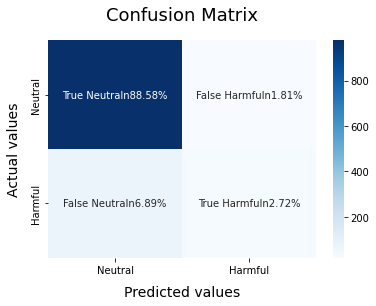

In [12]:
clf = LinearSVC(random_state=0)
y_pred1 = clf.fit(X_train_vec, y_train).decision_function(X_test_vec)
model_Evaluate(clf)

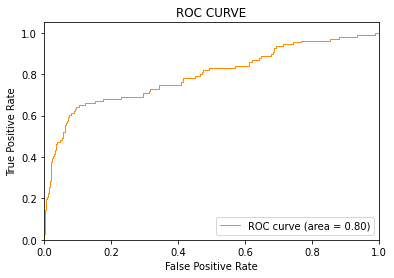

In [13]:
y_test1 = y_test.astype(int)
fpr, tpr, thresholds = roc_curve(y_test1, y_pred1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

## Model 2 - Logistic Regression

In [14]:
LRmodel = LogisticRegression(max_iter = 1000)
y_pred2 = LRmodel.fit(X_train_vec, y_train).decision_function(X_test_vec)

              precision    recall  f1-score   support

           0       0.91      1.00      0.95       997
           1       0.80      0.04      0.07       106

    accuracy                           0.91      1103
   macro avg       0.85      0.52      0.51      1103
weighted avg       0.90      0.91      0.87      1103



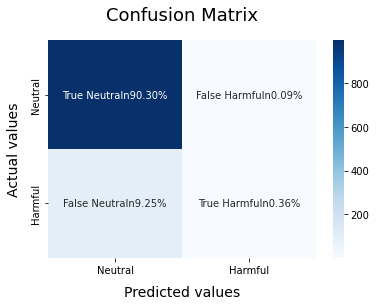

In [15]:
model_Evaluate(LRmodel)

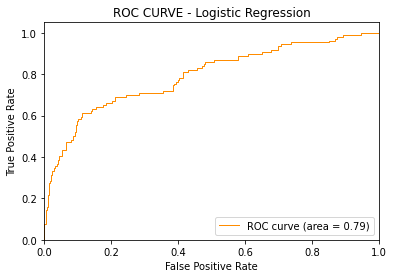

In [16]:
## ROC Curve
y_test2 = y_test.astype(int)
fpr, tpr, thresholds = roc_curve(y_test2, y_pred2)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE - Logistic Regression')
plt.legend(loc="lower right")
plt.show()

## Model 3 - Bidirectional LSTM


### Prepare data for NN model

In [20]:
temp = []
data_to_list = df['lemmatized'].values.tolist()
temp = data_to_list
list(temp[:5])

['faworyt tytuł cracovia zobaczyć typ sprawdzić',
 'brawo daria kibic dobry zły',
 'super polski premiera składać kwiat grób kolaborant doczekać czas',
 'inny droga',
 'odrzut natychmiastowy kwaśny mina problem']

In [22]:
list(temp[:5])

['faworyt tytuł cracovia zobaczyć typ sprawdzić',
 'brawo daria kibic dobry zły',
 'super polski premiera składać kwiat grób kolaborant doczekać czas',
 'inny droga',
 'odrzut natychmiastowy kwaśny mina problem']

In [23]:
data= np.array(temp)

In [24]:
labels = np.array(df['tag_val'])
y = []
for i in range(len(labels)):
    if labels[i] == "Neutral":
        y.append(0)
    if labels[i] == "Harmful":
        y.append(1)
y = np.array(y)
labels = tf.keras.utils.to_categorical(y, 2, dtype="float32")
del y

## Zamiana danych na tensory


In [26]:
max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[   0    0    0 ...  111 1464  327]
 [   0    0    0 ...   41    5   56]
 [   0    0    0 ... 1043  857   18]
 ...
 [   0    0    0 ...    8 4327 2379]
 [   0    0    0 ...  147  350   17]
 [   0    0    0 ...    0    0  204]]


In [27]:
print(labels)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [28]:
# Podział na trening i test
X_train, X_test, y_train, y_test = train_test_split(tweets, labels, random_state=0)
print(len(X_train),len(X_test),len(y_train),len(y_test))

8270 2757 8270 2757


In [30]:
model = Sequential()
model.add(layers.Embedding(max_words, 40, input_length=max_len))
model.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
model.add(layers.Dense(2,activation='softmax'))
model.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint("/content/drive/MyDrive/POLEVAL_6.1/biLSTM_model.hdf5", 
                              monitor='val_accuracy', 
                              verbose=1,
                              save_best_only=True, 
                              mode='auto', 
                              period=1,
                              save_weights_only=False)
history = model.fit(X_train, 
                     y_train, 
                     epochs=30, 
                     validation_data=(X_test, y_test),
                     callbacks=[checkpoint])

Epoch 1/30
259/259 [==============================] - ETA: 0s - loss: 0.3109 - accuracy: 0.9100
Epoch 00001: val_accuracy improved from -inf to 0.91077, saving model to /content/drive/MyDrive/POLEVAL_6.1/TEST/biLSTM_model.hdf5
259/259 [==============================] - 45s 156ms/step - loss: 0.3109 - accuracy: 0.9100 - val_loss: 0.2916 - val_accuracy: 0.9108
Epoch 2/30
259/259 [==============================] - ETA: 0s - loss: 0.2768 - accuracy: 0.9108
Epoch 00002: val_accuracy did not improve from 0.91077
259/259 [==============================] - 39s 151ms/step - loss: 0.2768 - accuracy: 0.9108 - val_loss: 0.2754 - val_accuracy: 0.9108
Epoch 3/30
259/259 [==============================] - ETA: 0s - loss: 0.2552 - accuracy: 0.9127
Epoch 00003: val_accuracy did not improve from 0.91077
259/259 [==============================] - 39s 151ms/step - loss: 0.2552 - accuracy: 0.9127 - val_loss: 0.2720 - val_accuracy: 0.9108
Epoch 4/30
259/259 [==============================] - ETA: 0s - loss:

In [54]:
model = keras.models.load_model("/content/drive/MyDrive/POLEVAL_6.1/biLSTM_model.hdf5")

In [56]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ',test_acc)

87/87 - 2s - loss: 0.2640 - accuracy: 0.9119 - 2s/epoch - 25ms/step
Model accuracy:  0.9118607044219971


In [35]:
predictions = model.predict(X_test)

In [58]:
predictions

array([[0.85594356, 0.14405647],
       [0.9423893 , 0.05761067],
       [0.9805228 , 0.01947721],
       ...,
       [0.9794805 , 0.02051945],
       [0.99507195, 0.00492798],
       [0.95149225, 0.04850771]], dtype=float32)

In [63]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import classification_report
y_pred =  np.around(predictions, decimals=0).argmax(axis=1)

print(classification_report(y_test.argmax(axis=1), y_pred))


              precision    recall  f1-score   support

           0       0.93      0.98      0.95      2511
           1       0.52      0.20      0.28       246

    accuracy                           0.91      2757
   macro avg       0.72      0.59      0.62      2757
weighted avg       0.89      0.91      0.89      2757



### Confusion matrix

In [36]:
# from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))

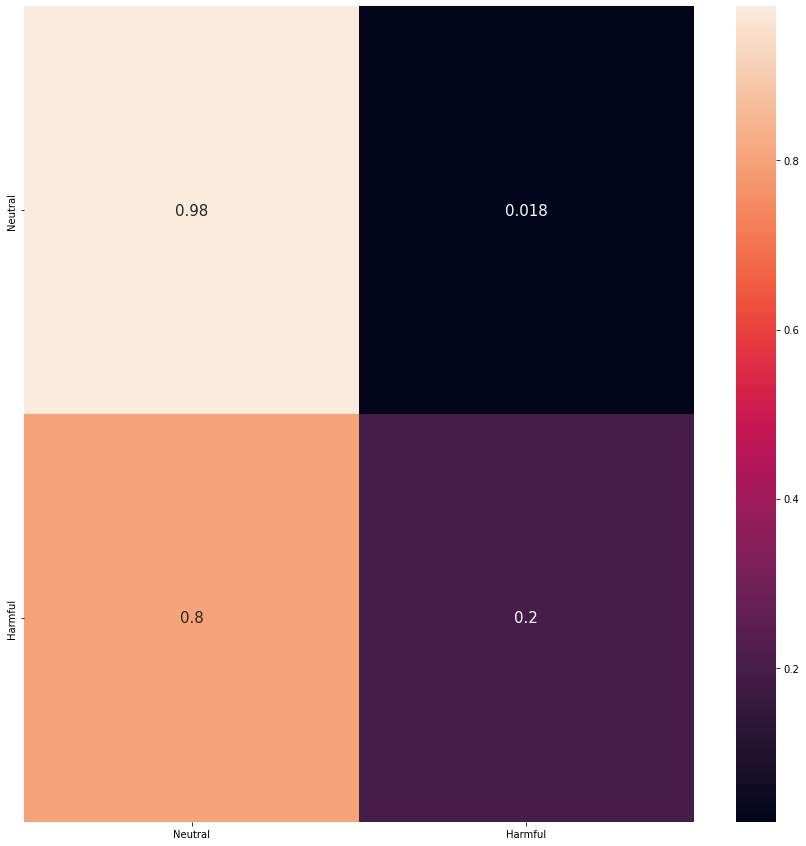

In [37]:
conf_matrix = pd.DataFrame(matrix, index = ['Neutral','Harmful'],columns = ['Neutral','Harmful'])
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})